I am developing a small game as a way to really nail down my programming skills. One of the challenges I came across as one does when programming a game from scratch, is pathfinding. My intitial attempts at pathfinding were with something simple like A*. However, do to the theming of my game, which is to say, survival horror, I thought it would be far more interesting to have an AI agent that behaves more like a real animal/actor. Needless to say, we will be sticking to A*. However, what I learned from this excursion into the qtable machine learning model has been extremely useful. 

This particular model (QTable) was chosen for a few reasons. Principle among them was its simplicity, interpretability, gauranteed convergence, and low computation requirements (optimization is an important factor in my game). Not only this, but the map that my game uses never changes, and therfore is a static environment which q tables tend to do well in. However, despite these "in theory" type reasons, personally I struggled to see why some tweaks or changes to variables would cause huge swings in performance or behaviors. For example, changing the epsilon decay from .999, to .995 would cause erratic wandering and the model never got anywhere. 

See below for insights into model performance.

In [20]:
from PIL import Image
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load the collision map
image = Image.open('simple2.png').convert('1')
collision_map = np.array(image)

In [21]:
class Agent:
    def __init__(self, start_pos):
        self.position = start_pos  # Starting position on the grid (x, y)
        self.previous_position = start_pos  # Store the initial position
        self.previous_distance = np.linalg.norm(np.array(start_pos) - np.array(target_pos))

    def get_state(self):
        return self.position

    def distance_to_target(self):
        return np.linalg.norm(np.array(self.position) - np.array(target_pos))

    def sense_wall(self, action, map_shape):
        x, y = self.position
        max_x, max_y = map_shape

        # Calculate potential new position based on the action
        if action == "up":
            new_pos = (x - 1, y)
        elif action == "down":
            new_pos = (x + 1, y)
        elif action == "left":
            new_pos = (x, y - 1)
        elif action == "right":
            new_pos = (x, y + 1)
        elif action == "assess":
            return self._check_nearby_walls()
        else:
            return False  # No valid action

        # Check if the new position is within the bounds of the map and not a wall
        if 0 <= new_pos[0] < max_x and 0 <= new_pos[1] < max_y:
            return collision_map[new_pos[0], new_pos[1]] == 1 
        return True  

    def _check_nearby_walls(self):
        """Check if any adjacent cells contain walls"""
        x, y = self.position
        directions = [(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1)]

        for dx, dy in directions:
            if 0 <= dx < collision_map.shape[0] and 0 <= dy < collision_map.shape[1]:
                if collision_map[dx, dy] == 1:
                    return True
        return False

    def move(self, action, map_shape):
        """ Move the agent if there's no wall in the direction of movement. """
        x, y = self.position
        max_x, max_y = map_shape

        if action == "up":
            new_pos = (x - 1, y)
        elif action == "down":
            new_pos = (x + 1, y)
        elif action == "left":
            new_pos = (x, y - 1)
        elif action == "right":
            new_pos = (x, y + 1)
        elif action == "assess":
            return  
        else:
            return  # No valid action

        if max_x > new_pos[0] >= 0 == collision_map[new_pos[0], new_pos[1]] and 0 <= new_pos[1] < max_y:
            self.previous_position = self.position
            self.position = new_pos

The sense wall function was added later on when I ascertained that the models q state space was too simple. Initially it was JUST its position in xy space. AS a result, the model really understood that closer is better. 

Also its an important element in Q-Table learning that your reward function respects the q-table's full state. What I mean is, your reward function cannot penalize the model for being near a wall, if it has no ability to sense walls. From the models perspective, without this crucial state space, its is being penalized randomly when at apsecific coordinates. What this leads to is overfitting where the model will always treat some specific coordinate as bad, and therefore it will fail to generalize. 

In [22]:
class QLearningAgent:
    def __init__(self, action_space, learning_rate=0.1, discount_factor=0.95, epsilon=1.0):
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon  
        self.epsilon_decay = 0.998462 
        self.min_epsilon = 0.01 
        self.q_table = {} 

    def choose_action(self, state, wall_detected, distance_to_target):
        full_state = (state, wall_detected, round(distance_to_target, 1))

        if full_state not in self.q_table:
            self.q_table[full_state] = {action: 0 for action in self.action_space}

        # Exploration or exploitation
        if random.uniform(0, 1) < self.epsilon:
            action = random.choice(self.action_space)
        else:
            action = self.best_action(full_state)  # Exploitation

        return action

    def best_action(self, state):
        """Select the action with the highest Q-value for the given state."""
        if state in self.q_table:
            # Get the action with the maximum Q-value
            return max(self.q_table[state], key=self.q_table[state].get)
        return random.choice(self.action_space)  # If no Q-values exist for the state, choose randomly

    def update_q_value(self, state, wall_detected, action, reward, next_state, next_wall_detected, distance_to_target,
                       next_distance_to_target):
        # Round distance to 1 decimal for consistent state representation
        full_state = (state, wall_detected, round(distance_to_target, 1))
        full_next_state = (next_state, next_wall_detected, round(next_distance_to_target, 1))

        # Ensure the states exist in the Q-table
        if full_state not in self.q_table:
            self.q_table[full_state] = {act: 0 for act in self.action_space}

        if full_next_state not in self.q_table:
            self.q_table[full_next_state] = {act: 0 for act in self.action_space}

        # Calculate Q-value update
        old_q_value = self.q_table[full_state][action]
        max_next_q_value = max(self.q_table[full_next_state].values())

        new_q_value = old_q_value + self.learning_rate * (
                reward + self.discount_factor * max_next_q_value - old_q_value
        )

        self.q_table[full_state][action] = new_q_value

    def decay_epsilon(self):
        """Gradually reduce epsilon, ensuring it doesn't go below min_epsilon"""
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

If you look at the state that is passed into the q table, you will notice that there are three arguments in the table. I added a third element to the state: distance_to_target.I determined that this is important because, again my reward function was not respecting the state in the q table. I cannot reward the model for getting closer to its target if it is has no "conception" of distance so to speak. I didnt want the model to associate reward with coordinates too strongly. 

In [23]:
def reward_function(agent_pos, target_pos, collision_map, previous_distance, wall_in_front,
                    previous_position, current_action, previous_action):
    reward = 0

    distance_to_target = np.linalg.norm(np.array(agent_pos) - np.array(target_pos))

    distance_change = previous_distance - distance_to_target

    if distance_change > 0:
        reward += distance_change  # Reward 1:1 for getting closer
    else:
        reward += distance_change * 0.2  # Penalize less for moving away

    if wall_in_front:
        if agent_pos != previous_position:
            reward += 1
        elif agent_pos == previous_position:
            reward -= 2 

    # Wall collision penalty
    if collision_map[agent_pos[0], agent_pos[1]] == 1:
        reward -= 10  # Significant penalty for being in a wall

    if current_action == "assess":
        if wall_in_front:
            reward += 1

    # Different action penalties
    if current_action == "assess":
        if previous_action == "assess":
            reward -= 1

    return reward

Later on, I added a 5th action that the model could take, which is "assess." I wanted that the agent should have the ability to not move, and check for walls around itself before making a move. Ultimately, this did not change the performance of the model even a little bit. f you look below and see the heat map or the proportion table, you can see the "assess" is quickly pruned by the qtable and is basically never used. 

In [24]:
class ModelTracker:
    def __init__(self):
        # Tracking metrics
        self.episode_rewards = []
        self.episode_steps = []
        self.epsilon_values = []
        self.q_table_sizes = []
        self.action_frequencies = {
            "up": [],
            "down": [],
            "left": [],
            "right": [],
            "assess": []  
        }
        self.distance_to_target = []

    def track_episode(self, episode, total_reward, steps, epsilon, q_table, action_counts, agent_pos, target_pos):
        # Record episode metrics
        self.episode_rewards.append(total_reward)
        self.episode_steps.append(steps)
        self.epsilon_values.append(epsilon)
        self.q_table_sizes.append(len(q_table))

        # Track action frequencies
        total_actions = sum(action_counts.values())
        for action, count in action_counts.items():
            self.action_frequencies[action].append(count / total_actions if total_actions > 0 else 0)

        # Calculate distance to target
        distance = np.linalg.norm(np.array(agent_pos) - np.array(target_pos))
        self.distance_to_target.append(distance)

    def plot_analysis(self):
        # Pad action frequencies to equal length
        max_length = max(len(freq) for freq in self.action_frequencies.values())

        # Pad action frequencies with zeros
        padded_frequencies = {
            action: (freq + [0] * (max_length - len(freq)))
            for action, freq in self.action_frequencies.items()
        }

        # Create a comprehensive visualization of the model's performance
        plt.figure(figsize=(20, 15))

        # Rewards Plot
        plt.subplot(2, 3, 1)
        plt.plot(self.episode_rewards, label='Rewards', color='green')
        plt.title('Rewards per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.legend()

        # Steps Plot
        plt.subplot(2, 3, 2)
        plt.plot(self.episode_steps, label='Steps', color='blue')
        plt.title('Steps per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Number of Steps')
        plt.legend()

        # Epsilon Decay
        plt.subplot(2, 3, 3)
        plt.plot(self.epsilon_values, label='Epsilon', color='red')
        plt.title('Epsilon Decay')
        plt.xlabel('Episode')
        plt.ylabel('Epsilon Value')
        plt.legend()

        # Q-Table Size
        plt.subplot(2, 3, 4)
        plt.plot(self.q_table_sizes, label='Q-Table Size', color='purple')
        plt.title('Q-Table Size Growth')
        plt.xlabel('Episode')
        plt.ylabel('Number of State-Action Pairs')
        plt.legend()

        # Action Frequencies Stacked Area
        plt.subplot(2, 3, 5)
        action_freq_array = np.array([
            padded_frequencies['up'],
            padded_frequencies['down'],
            padded_frequencies['left'],
            padded_frequencies['right'],
            padded_frequencies['assess'] 
        ])
        plt.stackplot(
            range(len(padded_frequencies['up'])),
            action_freq_array,
            labels=['Up', 'Down', 'Left', 'Right', 'Assess']  
        )
        plt.title('Action Frequency Distribution')
        plt.xlabel('Episode')
        plt.ylabel('Action Proportion')
        plt.legend(loc='upper right')

        # Distance to Target
        plt.subplot(2, 3, 6)
        plt.plot(self.distance_to_target, label='Distance', color='orange')
        plt.title('Distance to Target')
        plt.xlabel('Episode')
        plt.ylabel('Euclidean Distance')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Additional Heatmap of Action Frequencies
        plt.figure(figsize=(10, 6))
        sns.heatmap(
            action_freq_array,
            cmap='YlGnBu',
            xticklabels=range(0, len(action_freq_array[0]), 50),
            yticklabels=['Up', 'Down', 'Left', 'Right', 'Assess']  
        )
        plt.title('Action Frequency Heatmap')
        plt.xlabel('Episodes')
        plt.ylabel('Actions')
        plt.show()

In [25]:
class PathfindingEnv:
    def __init__(self, collision_map, target_pos):
        self.collision_map = collision_map
        self.target_pos = target_pos
        self.agent = Agent(start_pos=(200, 200))
        self.max_steps = None 
        self.current_steps = 0
        self.episode_path = [] 

    def reset(self, max_steps):
        self.agent = Agent(start_pos=(200, 200))
        self.current_steps = 0
        self.max_steps = max_steps  
        self.episode_path = []  
        return self.agent.position

    def step(self, action, previous_action):
        wall_in_front = self.agent.sense_wall(action, self.collision_map.shape)

        previous_position = self.agent.position 

        self.agent.move(action, self.collision_map.shape)

        if action != "assess":
            self.episode_path.append(self.agent.position)

        self.current_steps += 1

        reward = reward_function(self.agent.position, self.target_pos, self.collision_map,
                                 self.agent.previous_distance, wall_in_front, previous_position,
                                 action, previous_action)

        self.agent.previous_distance = np.linalg.norm(np.array(self.agent.position) - np.array(self.target_pos))

        if self.agent.position == self.target_pos:
            return self.agent.position, reward, True
        elif self.current_steps >= self.max_steps:
            return self.agent.position, reward, True
        return self.agent.position, reward, False

In [26]:
# Main training loop setup
map_shape = collision_map.shape
target_pos = (map_shape[0] // 2, map_shape[1] // 2)

env = PathfindingEnv(collision_map, target_pos=target_pos)
agent = QLearningAgent(action_space=["up", "down", "left", "right", "assess"])
rewards_list = []
epsilon_list = []

# Create the model tracker
model_tracker = ModelTracker()

In the training cell below, you can see that the steps are dynamically reset. I found that this was essential for the models performance because it prevented the model spending too much time learning random data from the first few episodes where the model truly is randomly wandering around. By making it so the first few episodes are shorter, this drastically reduced noise in the qtable. Initially, my model also had a dynamic epsilon, where if the model wasnt making enough progress, it would adjust the epsilon up between episodes. the thought he was that if it was getting stuck, and not making progress, it would allow the model to explore more and exploit less such that it could find its way out of local optima. It turned out that this was simply too finicky and the outcome for the model was virtually impossible to predict. Also I had a lot of trouble getting the state, next_state type arguments set up correctly, this is more of an aside than anything noteworthy. 

In [27]:
# Training loop
for episode in range(2000):  
    max_steps = min(episode * 5, 10000)  # More conservative step increase
    state = env.reset(max_steps=max_steps)
    done = False
    total_reward = 0
    action = None
    previous_action = None
    distance_to_target = 0

    # Track action counts for this episode
    action_counts = defaultdict(int)

    while not done:
        # Get current state and additional information
        state = env.agent.get_state()  # Current state
        wall_detected = env.agent.sense_wall(action, map_shape) if action else False
        distance_to_target = env.agent.distance_to_target()

        # Choose an action
        action = agent.choose_action(state, wall_detected, distance_to_target)
        action_counts[action] += 1

        # Execute action in the environment
        next_state, reward, done = env.step(action, previous_action)

        # Observe new state information
        next_wall_detected = env.agent.sense_wall(action, map_shape)
        next_distance_to_target = env.agent.distance_to_target()

        # Update Q-values
        agent.update_q_value(state, wall_detected, action, reward, next_state, next_wall_detected, distance_to_target,
                             next_distance_to_target)

        # Update state for next iteration
        state = next_state
        previous_action = action

        total_reward += reward

    # Decay epsilon
    agent.decay_epsilon()

    # Track episode metrics
    model_tracker.track_episode(
        episode,
        total_reward,
        env.current_steps,
        agent.epsilon,
        agent.q_table,
        action_counts,
        env.agent.position,
        target_pos
    )

    print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

Episode 0, Total Reward: -0.14146552280271862, Epsilon: 0.998462
Episode 1, Total Reward: -0.4246610715477346, Epsilon: 0.9969263654439999
Episode 2, Total Reward: 0.6952866293853277, Epsilon: 0.995393092693947
Episode 3, Total Reward: -0.020984012754706738, Epsilon: 0.9938621781173838
Episode 4, Total Reward: 5.229535345998556, Epsilon: 0.9923336180874391
Episode 5, Total Reward: 7.920652511286517, Epsilon: 0.9908074089828206
Episode 6, Total Reward: 3.082303299016166, Epsilon: 0.989283547187805
Episode 7, Total Reward: 6.049524987732411, Epsilon: 0.9877620290922301
Episode 8, Total Reward: 5.924980050056001, Epsilon: 0.9862428510914862
Episode 9, Total Reward: 4.903126277444835, Epsilon: 0.9847260095865075
Episode 10, Total Reward: 11.695043523541154, Epsilon: 0.9832115009837634
Episode 11, Total Reward: 9.887202625998043, Epsilon: 0.9816993216952503
Episode 12, Total Reward: 16.259149541613525, Epsilon: 0.980189468138483
Episode 13, Total Reward: 12.247511127460665, Epsilon: 0.97868

In the graphs below, as I mentioned above, you can see that the action "assess" quickly was never used, even though the model can be rewarded for assessing. This is proof that the model was in fact learning what the best actions to take were. I think that the q table growth is interesting. Its almost logarithmic, but it as some strange upticks near the top. I was never able to figure out what caused this. If you check the distance to target, you can see that the model never successfully gets to the target on this particular map. 

This has to do with a hurdle of navigating around large walls. If we think about the target as the apex, and either end of the wall as the base points of a triangle, we will see that the edge lengths of the triangle are longer than if we were to draw a line from the middle of the base to the apex. In other words, in order to go around the wall, the agent would need to get farther away from the target, which the reward function explicitly does not allow. 

I tried many different approaches to get the model to go around the walls, for example, I removed the penalty for moving away from the target, while still rewarding getting closer. However this caused the ai to wander around its starting point randomly, as it learned that moving away and then back earned it a reward. 

I was never able to mitgate this short coming of my pathfinding model, and to this day, it gets stuck on the wall every single iteration no matter what. Some things that have had interesting results is increasing the max steps and the number of episodes. 

This model does not take very long to run. I encourage you to try different episodes and max/min steps. 

As you can see, even with 2000 episodes, and 10,000 max steps, the model cannot make it past the wall. More worrying however, you can see that even though the distance never improved after a certrain point, the rewards continued to rise. This means that the model was doing something against the wall for which it was being rewarded, so it never felt compelled to actually get to the target, but the reasons for this can be found below. 

As for what to do in the future? 

-I think there needs to be discrete distance buckets. For example, the qtable treates the distances 10.1 and 10.2 as discrete, "equal in value" states, when really they should be in the same category so to speak. It also create a huge q table which does not lend itself to meaningful learning. This is because the q table records a value for every concievable state that it can be in, and makes it extremely prone to overfitting. 

-I need a more thorough "complete state," in other words, I think it needs more components to its complete state, and it needs a more complex reward function that entices the model to explore along walls. The model should be rewarded for exploring along walls until it can find its way to an opening or passageway that lets it get closer to the target.

-I should have also tuned the learning rate, and the discount rate, as neither of those were ever touched in the learning process. I was attempting to get the model to a good place, a working foundation before messing with more parameters.

-The model should have been built iteratively using curriculum learning. The model should have started on a very small map, with no obstacles, then saved to a file. Then the next iteration would have been more complex, with more tuned parameters. This would have allowed the model to create a better fit on the map data, and then generalized and specialized when it came time to detect walls.

-The model should have definitively used an experience function, to keep track of rare, but important experiences. As it is, the model only values repititive, short term reward conditions.

-The models needs a reward for curiosity. Whenever it explores a new area. I used to have these in the reward function. For example, I had an array of 100 positions. Then I found the average of those 100 positions. If the model was within +- 100 pixels of that average area, it was penalized, otherwise rewarded. However, this did not work as the model had other, more fundamental problems leaving this feature high and dry, or non-operative.

-Last, I think the model could have used temperature-based softmax exploration instead of epsilon-greedy. This was something that only came to my attention recently, but in short, rather than making purely random deicisions, this function picks randomnly among actions that are beneificial.In other words, certain actions in the qtable are assigned a value, and depending on the epsilon value, they might be chosen based on previous scores. So instead of being totally binary, random, or not, the model could have made "educated guesses." 

I read through the QLearning chapter in the book "Reinforcement Learning" by Sutton and Barto.

Here are some of the insights I obtained from it.


My model uses the standard Q-Learning update rule that book outlines.

new_q_value = old_q_value + learning_rate * (
    reward + discount_factor * max_next_q_value - old_q_value
)


My model also uses the standard exploration model outlined in the book.

Q(s,a) ← Q(s,a) + α[R + γ max_a Q(s',a') - Q(s,a)]

--------------------

From the book, I learned that I probably should have used N step returns with eligibility traces. In short, this allows the model to look forward n steps, to determine potential reward. AS it is my model only looks one step forward.

From the book, I see that having a decaying learning rate is important, as it prevent oscillation in the final policy and helps stabilize the learning process, as well as ensure convergence. 

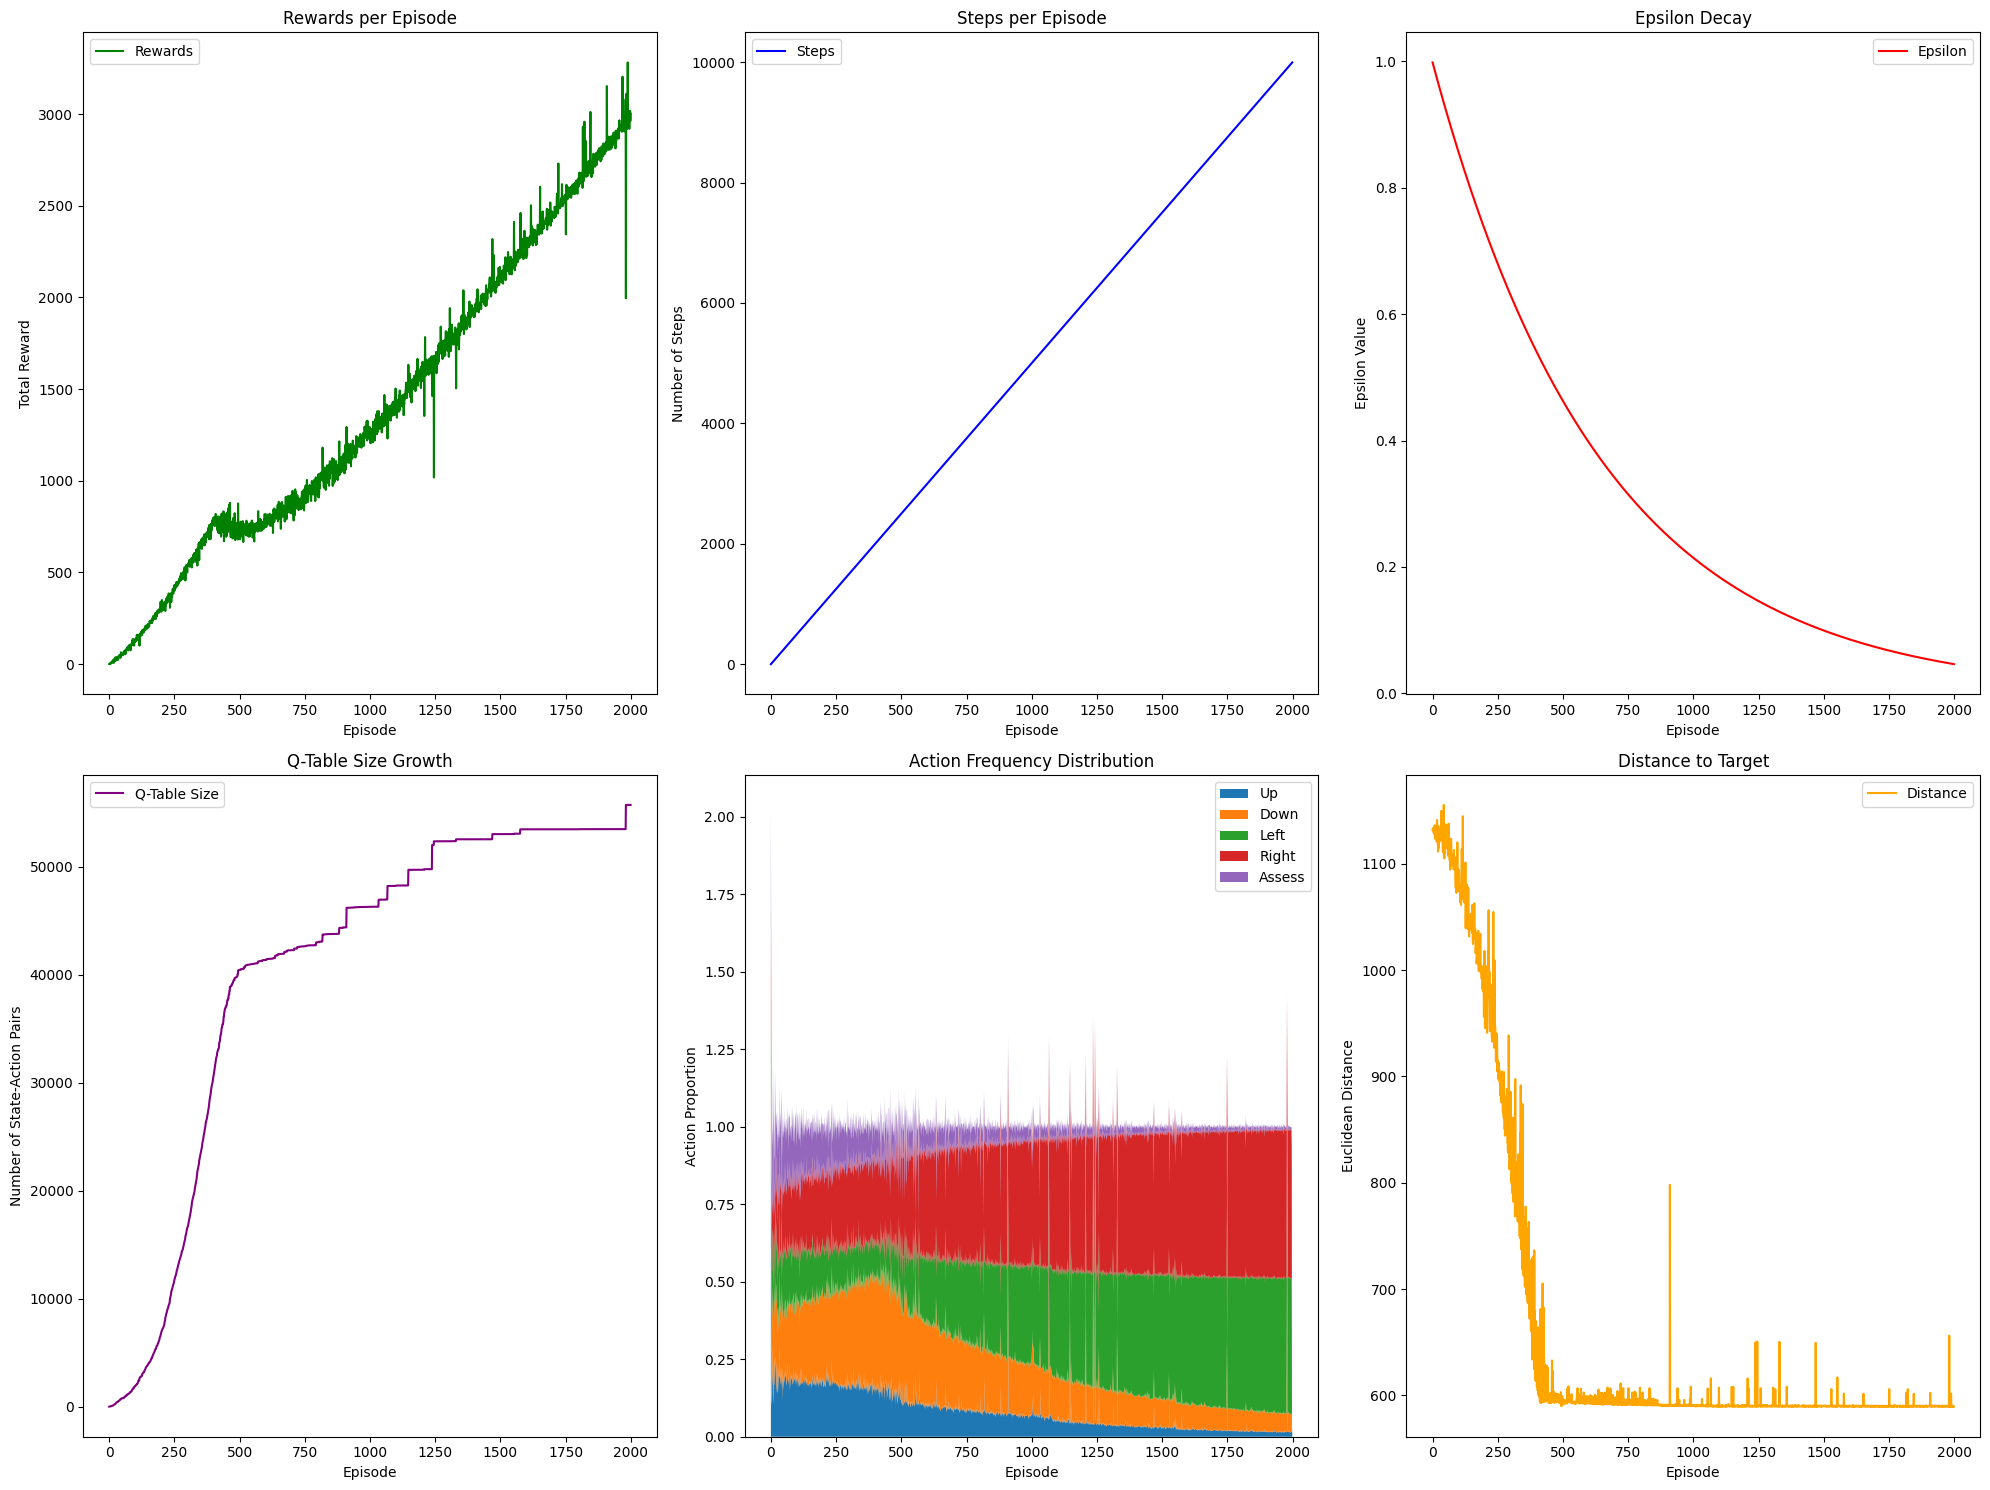

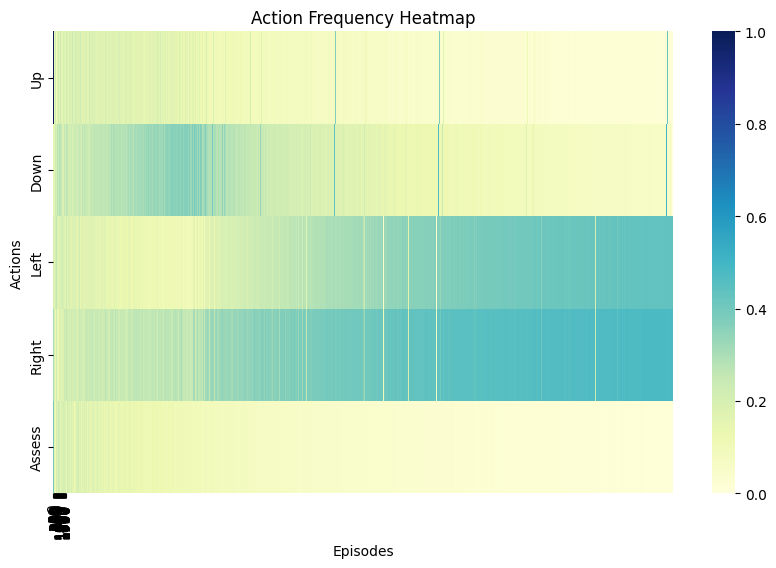

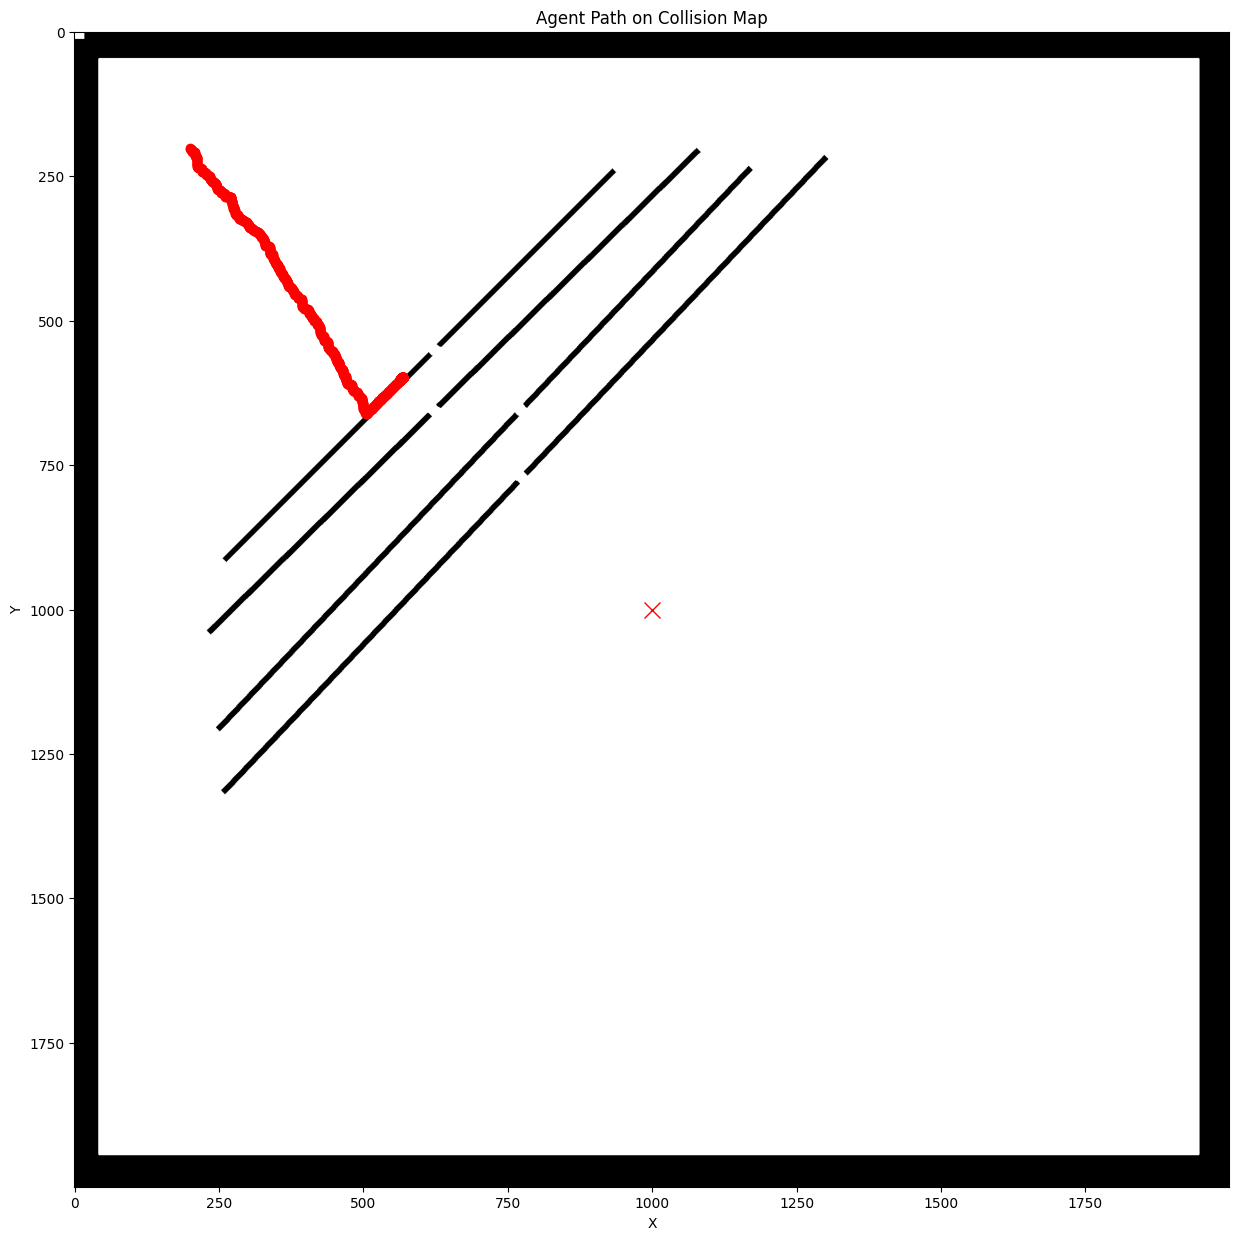

In [28]:
# Plot the comprehensive analysis after training
model_tracker.plot_analysis()

plt.figure(figsize=(15, 15))
plt.imshow(collision_map, cmap='binary')
plt.plot([pos[1] for pos in env.episode_path], [pos[0] for pos in env.episode_path], '-o', color='r')
plt.plot(target_pos[1], target_pos[0], 'rx', markersize=12)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Agent Path on Collision Map')
plt.show()